# Import all packages

In [2]:
import numpy as np
import sep
import astropy.io.fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

# Download FITS inage

In [3]:
#download file
image_file = 'f105w.fits'
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)

#open fits image
hdu_list = fits.open(image_file)
hdu_list.info()

image_data = hdu_list[0].data

#display image data
print(type(image_data))
print(image_data.shape)

hdu_list.close()

image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(3600, 3600)
Filename: f105w.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   
<class 'numpy.ndarray'>
(3600, 3600)
<class 'numpy.ndarray'>
(3600, 3600)


# Display image

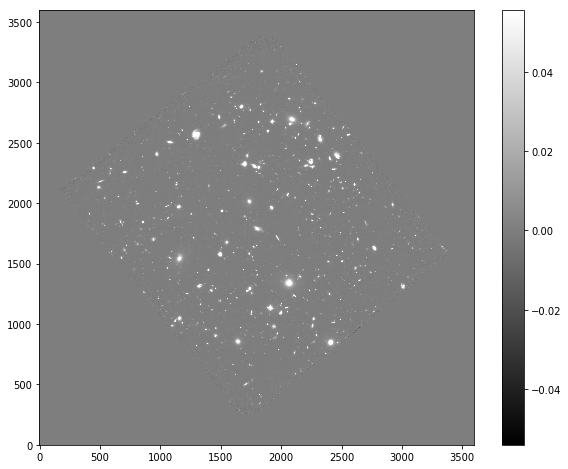

In [4]:
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('f105w.png')

# Subtract the background

0.0
0.0005398219218477607


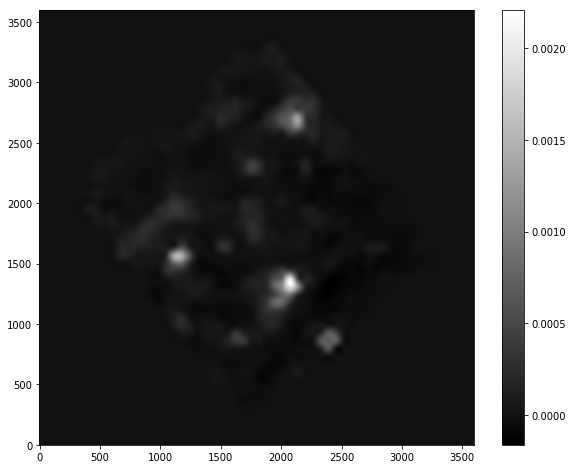

In [7]:
# measure a spatially varying background on the image
image_data = image_data.byteswap().newbyteorder()
bkg = sep.Background(image_data)

bkg = sep.Background(image_data, bw=64, bh=64, fw=3, fh=3)

# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)


# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('background.png')

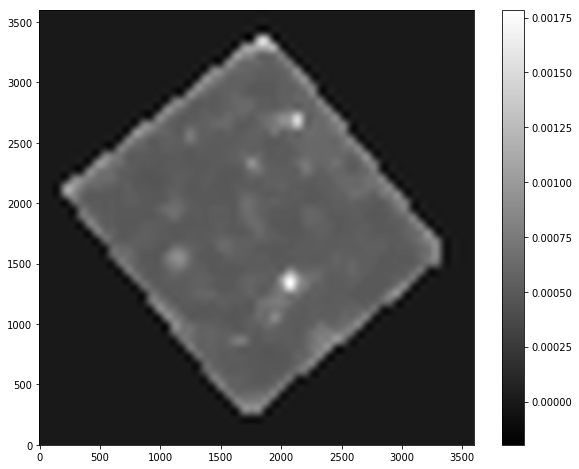

In [9]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

# subtract the background
data_sub = image_data - bkg
plt.savefig('noise.png')

# Object detection

In [10]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
# how many objects were detected
len(objects)

8640

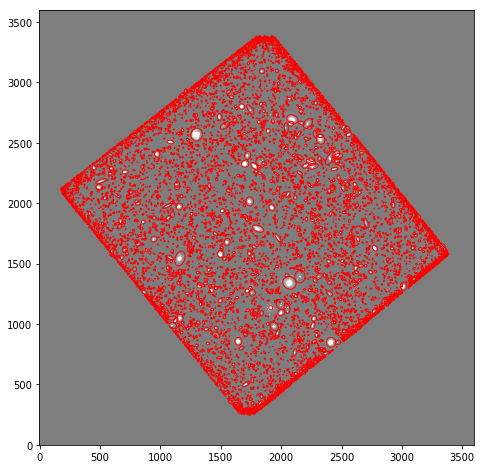

In [12]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('objects.png')

# Plot histogram

NameError: name 'x' is not defined

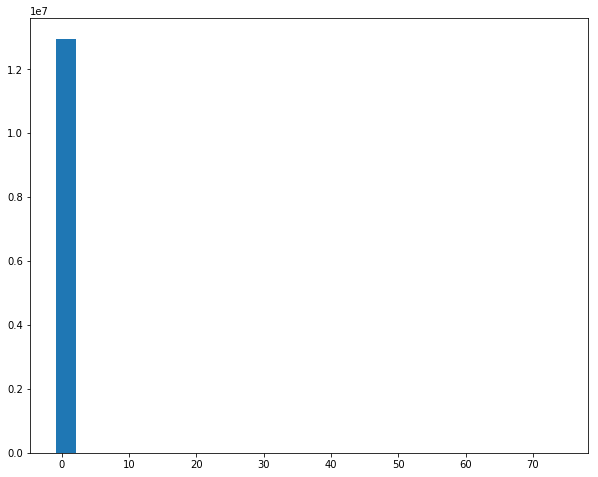

In [13]:
histogram = plt.hist(image_data.flatten(), bins='auto')

# Aperture photometry

In [14]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


[Text(1, 0, '5,000'), Text(1, 0, '10,000'), Text(1, 0, '20,000')]

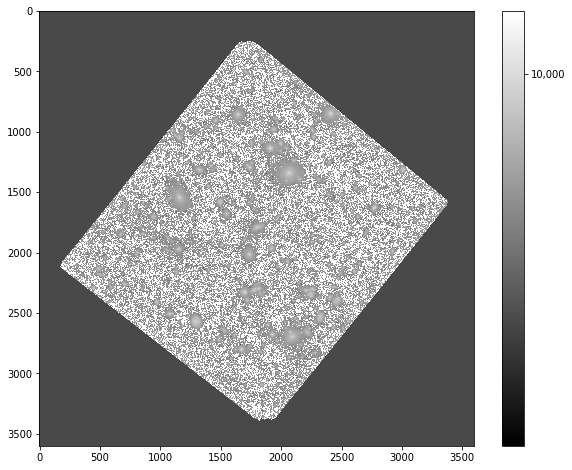

In [15]:
from matplotlib.colors import LogNorm

plt.imshow(image_data, cmap='gray', norm=LogNorm())

cbar = plt.colorbar(ticks=[5.e3,1.34,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])